In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [3]:
bitcoin_data_train = yf.download('BTC-USD', start='2019-01-01', end='2024-01-01')
bitcoin_data_test = yf.download('BTC-USD', start='2024-01-01' , end='2024-04-28')

print("Example of training data:")
print(bitcoin_data_train.head())
print("\nExample of test data:")
print(bitcoin_data_test.head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Example of training data:
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020  3843.520020   
2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424  3943.409424   
2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211  3836.741211   
2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529  3857.717529   
2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580  3845.194580   

                Volume  
Date                    
2019-01-01  4324200990  
2019-01-02  5244856836  
2019-01-03  4530215219  
2019-01-04  4847965467  
2019-01-05  5137609824  

Example of test data:
                    Open          High           Low         Close  \
Date                                                                 
2024-01-01  42280.234375  44175.437500  42214.976562  44167.332031   
2024-01-02  

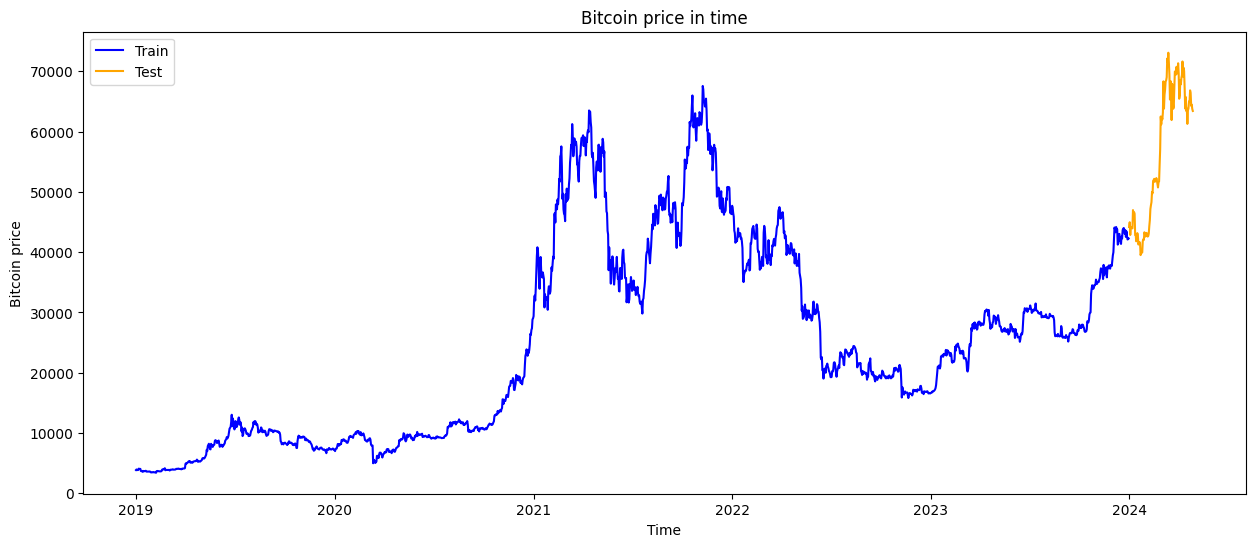

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(bitcoin_data_train.index, bitcoin_data_train['Close'], label='Train', color='blue')
plt.plot(bitcoin_data_test.index, bitcoin_data_test['Close'], label='Test', color='orange')
plt.title('Bitcoin price in time')
plt.xlabel('Time')
plt.ylabel('Bitcoin price')
plt.legend()
plt.show()

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_data_train_scaled = scaler.fit_transform(np.array(bitcoin_data_train['Close']).reshape(-1, 1))
bitcoin_data_test_scaled = scaler.transform(np.array(bitcoin_data_test['Close']).reshape(-1, 1))

In [26]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(bitcoin_data_train_scaled)):
    X_train.append(bitcoin_data_train_scaled[i - n_past:i, 0])
    y_train.append(bitcoin_data_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(bitcoin_data_test_scaled)):
    X_test.append(bitcoin_data_test_scaled[i - n_past:i, 0])
    y_test.append(bitcoin_data_test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Training data size:", X_train.shape, y_train.shape)
print("Test data size:", X_test.shape, y_test.shape)


Training data size: (1766, 60, 1) (1766,)
Test data size: (58, 60, 1) (58,)


In [27]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_11 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [28]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
56/56 [==============================] - 7s 14ms/step - loss: 0.0217
Epoch 2/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0038
Epoch 3/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 4/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0040
Epoch 5/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 6/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0031
Epoch 7/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0031
Epoch 8/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0024
Epoch 9/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0024
Epoch 10/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 11/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0023
Epoch 12/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 13/100
56/56 [=====

2/2 [==============================] - 1s 10ms/step


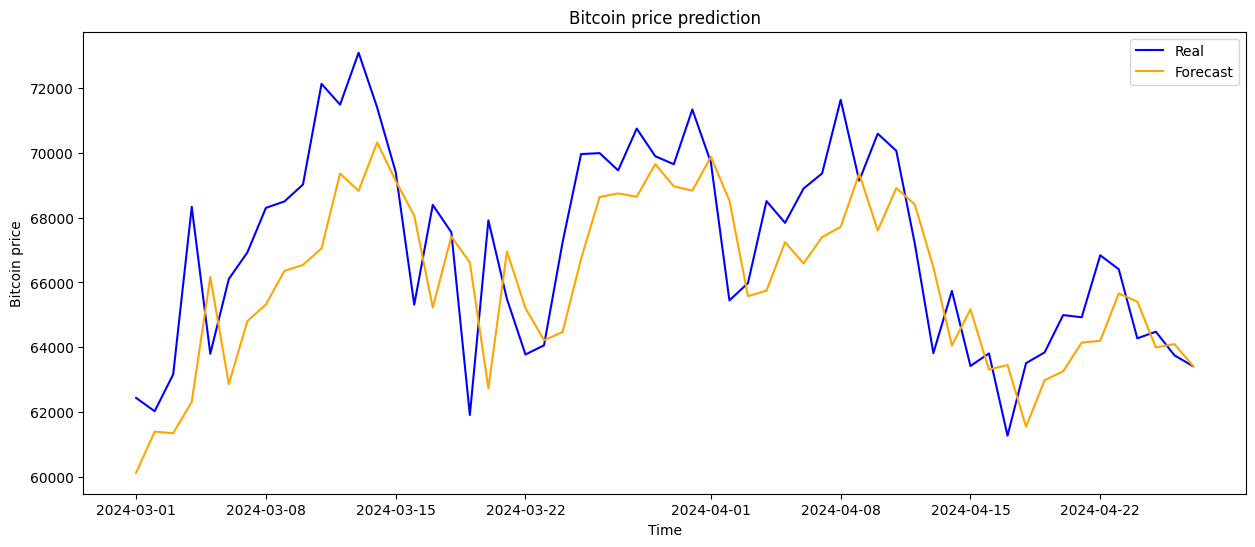

In [29]:
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

plt.figure(figsize=(15, 6))
plt.plot(bitcoin_data_test.index[n_past:], bitcoin_data_test['Close'][n_past:], label='Real', color='blue')
plt.plot(bitcoin_data_test.index[n_past:], predicted_price, label='Forecast', color='orange')
plt.title('Bitcoin price prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin price')
plt.legend()
plt.show()

In [30]:
def compare_trend(original_prices, predicted_prices):
    original_changes = [(original_prices[i] - original_prices[i-1]) / original_prices[i-1] for i in range(1, len(original_prices))]
    predicted_changes = [(predicted_prices[i] - predicted_prices[i-1]) / predicted_prices[i-1] for i in range(1, len(predicted_prices))]

    original_avg_change = sum(original_changes) / len(original_changes)
    predicted_avg_change = sum(predicted_changes) / len(predicted_changes)

    if original_avg_change < predicted_avg_change:
        return "It has increased"
    elif original_avg_change > predicted_avg_change:
        return "It has decreased"
    else:
        return "It has remains fixed"

trend_comparison = compare_trend(bitcoin_data_test['Close'][n_past:], predicted_price)
print("Bitcoin price behavior over time as predicted by the model : " + trend_comparison)


Bitcoin price behavior over time as predicted by the model : It has increased


## **The answer to part `i` is written in the document.**